In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

# auxilliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

# Qiskit Optimization
<br>

Stefan Woerner<br>
IBM Quantum, IBM Research - Zurich<br>
<br>

https://github.com/stefan-woerner/uimp_csic_2020_summer_school_on_quantum_computing

# Outline

1. Introduction

2. QUBO & Ising Hamiltonians

3. VQE & QAOA

# 1. Introduction

## Quantum Circuits

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator
from qiskit.providers.aer import QasmSimulator

backend = QasmSimulator(shots=1024)

In [3]:
qc = QuantumCircuit(2)
# qc.x(0)
# qc.x(1)
# qc.barrier()
# qc.h(0)
# qc.h(1)
# qc.cx(0, 1)
# qc.h(0)
# qc.h(1)
qc.measure_all()
qc.draw()

░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1

In [4]:
backend.run(qc).result().get_counts()

{'00': 1024}

In [5]:
# plot statevector
print(np.round(np.real(Statevector(qc.remove_final_measurements(inplace=False)).data), decimals=3))

[1. 0. 0. 0.]


In [6]:
print(np.round(np.real(Operator(qc.remove_final_measurements(inplace=False)).data), decimals=3))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


## Quadratically Constrained Quadratic Programs

<br>

$$
\min_{x \in X} \, x^T A x + b^T x + c \\
\,\\
\text{subject to}\\
x^T A_i x + b_i^T x + c_i \leq 0, \quad i=1, \ldots, r,\\
\,\\
\text{where}\\
X = \mathbb{R}^n \times \mathbb{Z}^m \times \{0, 1\}^k\\
A \in \mathbb{R}^{(n+m+k) \times (n+m+k)}\\
b \in \mathbb{R}^{(n+m+k)}\\
c \in \mathbb{R}
$$

## Quadratic Unconstrained Binary Optimization (QUBO)

<br>

$$
\min_{x \in \{0, 1\}^k} \, x^T A x + c \\
$$

For binary variables $x^2 = x$, thus, the linear part can be added to the diagonal of the quadratic part.

## Example: MaxCut

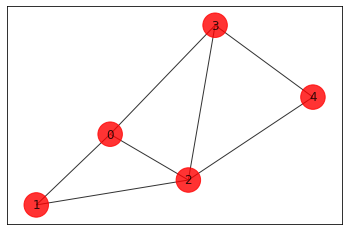

In [7]:
# create graph
G = nx.Graph()

# add nodes
n = 5
G.add_nodes_from(range(n))

# add edges: tuple is (i,j,weight) where (i,j) is the edge
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
G.add_weighted_edges_from(edges)

# plot graph
plot_result(G, [0]*n)

## Example: Modeling MaxCut with DOcplex

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j)
$$

In [8]:
from docplex.mp.model import Model

mdl = Model('MaxCut')
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))

objective = mdl.sum([ w * (x[i] + x[j] - 2*x[i]*x[j]) for (i, j, w) in edges])
mdl.maximize(objective)

mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[5];

maximize
 3 x0 + 2 x1 + 4 x2 + 3 x3 + 2 x4 [ - 2 x0*x1 - 2 x0*x2 - 2 x0*x3 - 2 x1*x2
 - 2 x2*x3 - 2 x2*x4 - 2 x3*x4 ];
 
subject to {

}


## Example: Adding a Constraint

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j) \\
\text{subject to:} \sum_{i=0}^{n-1} x_i = b
$$

In [9]:
b = 2
mdl.add_constraint(mdl.sum(x) == b)
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[5];

maximize
 3 x0 + 2 x1 + 4 x2 + 3 x3 + 2 x4 [ - 2 x0*x1 - 2 x0*x2 - 2 x0*x3 - 2 x1*x2
 - 2 x2*x3 - 2 x2*x4 - 2 x3*x4 ];
 
subject to {
 x0 + x1 + x2 + x3 + x4 == 2;

}


## Example: Create and solve `QuadraticProgram` with DOcplex

fval=5.0, x0=0.0, x1=0.0, x2=1.0, x3=1.0, x4=0.0, status=SUCCESS


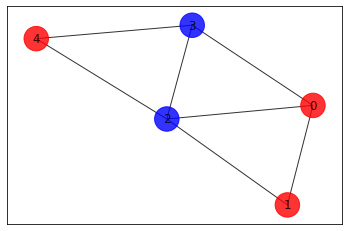

In [10]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import CplexOptimizer

# convert from DOcplex model to Qiskit Quadratic Program
qp = from_docplex_mp(mdl)

# Solve Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_result(G, result.x)

## Questions?

# 2. QUBO & Ising Hamiltonian

## Conversion to QUBO

Qiskit's Optimization module provides converters for Quadratic Programs:

In [11]:
from qiskit_optimization.converters import (
    InequalityToEquality,     # converts inequality constraints to equality constraints by adding slack variables
    LinearEqualityToPenalty,  # converts linear equality constraints to quadratic penalty terms 
    IntegerToBinary,          # converts integer variables to binary variables
    QuadraticProgramToQubo    # combines the previous three converters
)

## Linear Equality Constraint to Quadratic Penalty Term

In [12]:
lineq2penalty = LinearEqualityToPenalty(penalty=1)
qp_wo_constr = lineq2penalty.convert(qp)
print(qp_wo_constr.prettyprint())

Problem name: MaxCut

Maximize
  -x0^2 - 4*x0*x1 - 4*x0*x2 - 4*x0*x3 - 2*x0*x4 - x1^2 - 4*x1*x2 - 2*x1*x3
  - 2*x1*x4 - x2^2 - 4*x2*x3 - 4*x2*x4 - x3^2 - 4*x3*x4 - x4^2 + 7*x0 + 6*x1
  + 8*x2 + 7*x3 + 6*x4 - 4

Subject to
  No constraints

  Binary variables (5)
    x0 x1 x2 x3 x4



fval=5.0, x0=1.0, x1=0.0, x2=0.0, x3=0.0, x4=1.0, status=SUCCESS


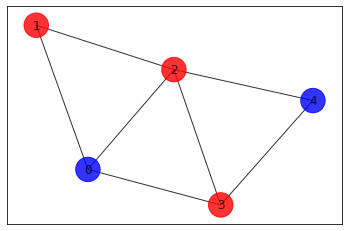

In [13]:
# Solve converted Quadratic Program using CPLEX
result = cplex.solve(qp_wo_constr)
print(result)
plot_result(G, result.x)

## Mapping of QUBO to Ising Hamiltonian

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

1. Substitute<br>
$x_i = (1 - z_i)/2,$<br>
where $z_i \in \{-1, +1\}$.
<br>

2. Replace<br>
$z_i z_j = \sigma_Z^i \otimes \sigma_Z^j$, and<br>
$z_i = \sigma_Z^i$,<br>
where $\sigma_Z^i$ denotes the Pauli Z-matrix $\left(\begin{array}{cc}1&0\\0&-1\end{array}\right)$ on the <font color="blue">$i$-th qubit</font>.

## From QUBO to Finding Hamiltonian Groundstates

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

which has been mapped to an Ising Hamiltonian:
$$
H = \sum_{i,j=0}^{n-1} \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j + \sum_{i=0}^{n-1} \tilde{b}_i \sigma_Z^i + \tilde{c}
$$

Finding the groundstate of $H$ is equivalent to solving the QUBO:

$$
\min_{|\psi\rangle_n} \, \langle \psi |H| \psi \rangle_n
$$

<br>

<b>Remark:</b> $H$ is diagonal, and thus, all computational basis states $|x\rangle_n$ are eigenstates.

In [14]:
H, offset = qp_wo_constr.to_ising()
print('offset =', offset)
print()
print('H =', H)

offset = -2.0

H = -0.5 * IIIIZ
- 0.5 * IIIZI
- 0.5 * IIZII
- 0.5 * IZIII
- 0.5 * ZIIII
+ 1.0 * IIIZZ
+ 1.0 * IIZIZ
+ 1.0 * IIZZI
+ 1.0 * IZIIZ
+ 0.5 * IZIZI
+ 1.0 * IZZII
+ 0.5 * ZIIIZ
+ 0.5 * ZIIZI
+ 1.0 * ZIZII
+ 1.0 * ZZIII


dim(H): (32, 32)
[[ 6.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4.  0.  0.]
 [ 0.  0.  0. ...  0.  3.  0.]
 [ 0.  0.  0. ...  0.  0. 11.]]


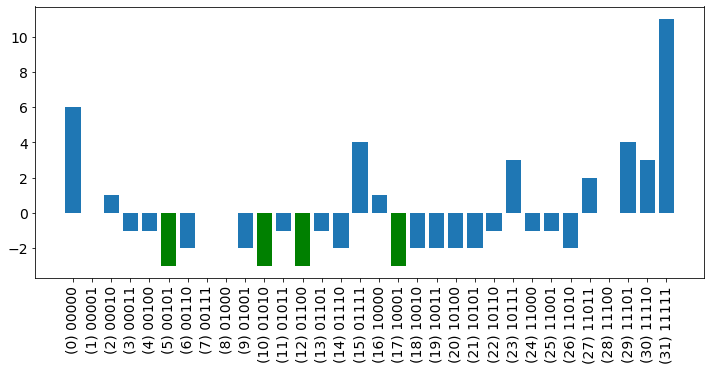

In [15]:
# print Ising Hamiltonian as matrix
H_matrix = np.real(H.to_matrix())
print('dim(H):', H_matrix.shape)
print(H_matrix)

# plot diagonal of matrix
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), H_matrix.diagonal())
plt.bar(opt_indices, H_matrix.diagonal()[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## 3. VQE & QAOA

## Variational Quantum Eigensolver (VQE)

Replace minimization over all $|\psi\rangle$ by minimization over a parametrized subset $|\psi(\theta)\rangle$:
<br>

$$
\min_{\theta} \langle \psi(\theta) |H| \psi(\theta) \rangle
$$

## VQE with `RealAmplitudes` Circuit

In [16]:
from qiskit.providers.aer import QasmSimulator
from qiskit.algorithms.optimizers import COBYLA

backend = QasmSimulator(method='statevector')
optimizer = COBYLA()

In [17]:
from qiskit.circuit.library import RealAmplitudes

qc = RealAmplitudes(5, reps=1)
qc.decompose().draw(fold=120)

┌──────────┐                              ┌──────────┐                                         
q_0: ┤ Ry(θ[0]) ├──■────■─────────■─────────■──┤ Ry(θ[5]) ├─────────────────────────────────────────
     ├──────────┤┌─┴─┐  │         │         │  └──────────┘     ┌──────────┐                        
q_1: ┤ Ry(θ[1]) ├┤ X ├──┼────■────┼────■────┼────────────────■──┤ Ry(θ[6]) ├────────────────────────
     ├──────────┤└───┘┌─┴─┐┌─┴─┐  │    │    │                │  └──────────┘┌──────────┐            
q_2: ┤ Ry(θ[2]) ├─────┤ X ├┤ X ├──┼────┼────┼───────■────────┼───────■──────┤ Ry(θ[7]) ├────────────
     ├──────────┤     └───┘└───┘┌─┴─┐┌─┴─┐  │     ┌─┴─┐      │       │      └──────────┘┌──────────┐
q_3: ┤ Ry(θ[3]) ├───────────────┤ X ├┤ X ├──┼─────┤ X ├──────┼───────┼───────────■──────┤ Ry(θ[8]) ├
     ├──────────┤               └───┘└───┘┌─┴─┐   └───┘    ┌─┴─┐   ┌─┴─┐       ┌─┴─┐    ├──────────┤
q_4: ┤ Ry(θ[4]) ├─────────────────────────┤ X ├────────────┤ X ├───┤ X ├───────┤ X ├────┤ Ry(θ[9]) ├
     └──────────┘                         └───┘            └───┘   └───┘       └───┘    └──────────┘

In [18]:
from qiskit.algorithms import VQE

vqe = VQE(qc, optimizer=optimizer, quantum_instance=backend)
result = vqe.compute_minimum_eigenvalue(H)

print('optimal value:', np.round(np.real(result.eigenvalue), decimals=4))

optimal value: -2.6045


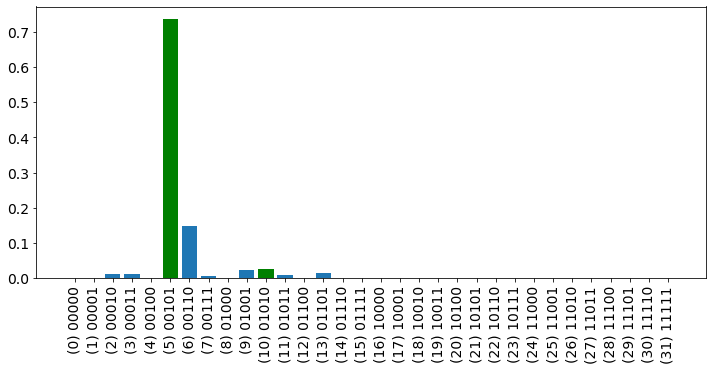

In [19]:
# plot probabilities
probabilities = np.zeros(2**n)
for x, a in result.eigenstate.items():
    probabilities[int(x, 2)] = np.abs(a)**2

plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How should we choose $|\psi(\theta)\rangle$ for a particular problem?

## Quantum Approximate Optimization Algorithm (QAOA)

Trotterized Annealing leads to very long circuits, since the required simulation time and number of Trotter steps significantly increases with the problem size.

Thus, as introduced in [1], one can fix the number of steps to $p$, and let a classical optimizer find the best angles $\gamma_t$ and $\beta_t$, $t = 1, \ldots, p$, instead of following a fixed annealing schedule.

This is known as the <font color="blue"><b>Quantum Approximate Optimization Algorithm</b></font>.

<br>
<br>
[1] A Quantum Approximate Optimization Algorithm.<br>Edward Farhi, Jeffrey Goldstone, Sam Gutmann.<br>
https://arxiv.org/abs/1411.4028

In [20]:
from qiskit.algorithms import QAOA

p = 1
qaoa = QAOA(reps=p, optimizer=optimizer, quantum_instance=backend, initial_point=np.random.rand(2*p))
result = qaoa.compute_minimum_eigenvalue(H)

print('optimal value:', np.round(np.real(result.eigenvalue), decimals=4))

optimal value: -0.375


In [21]:
qaoa.ansatz.decompose().decompose().draw(fold=120)

┌─────────────┐┌───────────────┐                                                                           »
q_0: ┤ U3(π/2,0,π) ├┤ Rz(-1.0*γ[0]) ├─■──────────────■─────────────────────────────■────────────────────────────»
     ├─────────────┤├───────────────┤ │ZZ(2.0*γ[0])  │                             │                            »
q_1: ┤ U3(π/2,0,π) ├┤ Rz(-1.0*γ[0]) ├─■──────────────┼──────────────■──────────────┼──────────────■─────────────»
     ├─────────────┤├───────────────┤                │ZZ(2.0*γ[0])  │ZZ(2.0*γ[0])  │              │             »
q_2: ┤ U3(π/2,0,π) ├┤ Rz(-1.0*γ[0]) ├────────────────■──────────────■──────────────┼──────────────┼─────────────»
     ├─────────────┤├───────────────┤                                              │ZZ(2.0*γ[0])  │ZZ(1.0*γ[0]) »
q_3: ┤ U3(π/2,0,π) ├┤ Rz(-1.0*γ[0]) ├──────────────────────────────────────────────■──────────────■─────────────»
     ├─────────────┤├───────────────┤                                                                           »
q_4: ┤ U3(π/2,0,π) ├┤ Rz(-1.0*γ[0]) ├───────────────────────────────────────────────────────────────────────────»
     └─────────────┘└───────────────┘                                                                           »
«                    ┌──────────────┐                                                               
«q_0: ─■─────────────┤ Rx(2.0*β[0]) ├───────────────────────────────────────────────────────────────
«      │             └──────────────┘               ┌──────────────┐                                
«q_1: ─┼──────────────────────────────■─────────────┤ Rx(2.0*β[0]) ├────────────────────────────────
«      │                              │             └──────────────┘┌──────────────┐                
«q_2: ─┼──────────────■───────────────┼──────────────■──────────────┤ Rx(2.0*β[0]) ├────────────────
«      │              │ZZ(2.0*γ[0])   │              │              └──────────────┘┌──────────────┐
«q_3: ─┼──────────────■───────────────┼──────────────┼───────────────■──────────────┤ Rx(2.0*β[0]) ├
«      │ZZ(1.0*γ[0])                  │ZZ(1.0*γ[0])  │ZZ(2.0*γ[0])   │ZZ(2.0*γ[0])  ├──────────────┤
«q_4: ─■──────────────────────────────■──────────────■───────────────■──────────────┤ Rx(2.0*β[0]) ├
«                                                                                   └──────────────┘

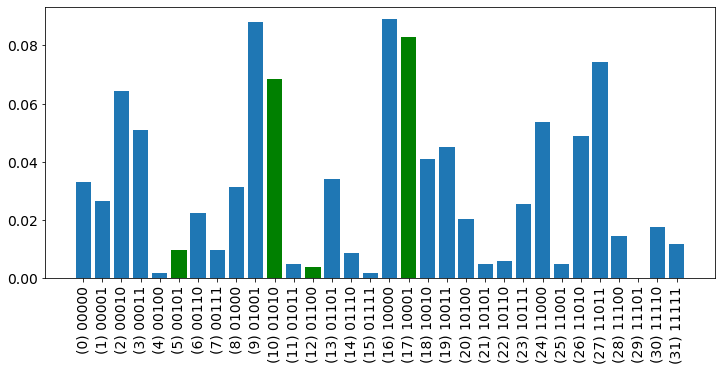

In [22]:
# plot probabilities
probabilities = np.zeros(2**n)
for x, a in result.eigenstate.items():
    probabilities[int(x, 2)] = np.abs(a)**2
    
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [23]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# construct Minimum Eigen Optimizer based on QAOA
qaoa_opt = MinimumEigenOptimizer(qaoa)

# solve Quadratic Program
result = qaoa_opt.solve(qp)

fval=5.0, x0=1.0, x1=0.0, x2=1.0, x3=0.0, x4=0.0, status=SUCCESS


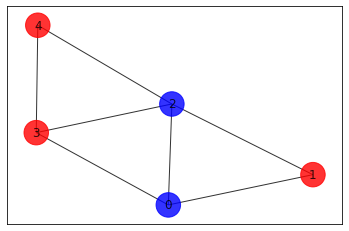

In [24]:
print(result)
plot_result(G, result.x)

## Questions?

# What's next...

# Further Resources

<br>

- Medium article on Qiskit's Optimization module:<br>
https://medium.com/qiskit/ <br>
"A Walkthrough of Qiskit’s New Optimization Module"
<br>

- Qiskit Text Book:<br>
https://qiskit.org/textbook/ <br>
Sections on QAOA and Grover Search
<br>

- Qiskit Tutorials:<br>
https://qiskit.org/documentation/tutorials/optimization/ <br>
Tutorials on all algorithms, converters, etc.

<div>
    <center>
        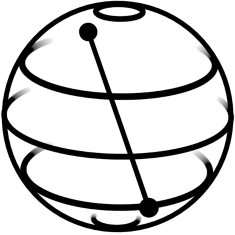
        <br>
        <br>
        Thank you!
    </center>
</div>